<a href="https://colab.research.google.com/github/emaudealtema/Deep_learning_repository/blob/master/Detection_d_Objet_dans_des_images_satellitaires_avec_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import CSVLogger, SaveModelCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
!wget https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
!unzip UCMercedLanduse.zip

--2020-10-08 01:42:31--  https://www.dropbox.com/s/u83ae1efaah2w9o/UCMercedLanduse.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip [following]
--2020-10-08 01:42:31--  https://www.dropbox.com/s/raw/u83ae1efaah2w9o/UCMercedLanduse.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebd96d57e819b5d429d43b7429.dl.dropboxusercontent.com/cd/0/inline/BA2tmImukzM_zKb-A-jhcQJoJ7sVcWfPGkNhPtGzu0HIlRYa6rCM3hxnaqt1KBobwWbWZRMdSXc5lXmkIDsJbj6hm_lgvbs4LeqYwp96Daa3NNeTGbkm4zdHQgeB7x82_Y4/file# [following]
--2020-10-08 01:42:31--  https://ucebd96d57e819b5d429d43b7429.dl.dropboxusercontent.com/cd/0/inline/BA2tmImukzM_zKb-A-jhcQJoJ7sVcWfPGkNhPtGzu0HIlRYa6rCM3hxnaqt1KBobwWbWZRMdSXc5lXmkIDsJbj6hm_lgv

In [4]:
df = pd.read_csv("UCMerced/multilabels.txt", sep="\t")
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

In [5]:
df.shape

(2100, 18)

In [6]:
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ["class", "Count"]
class_count.drop(class_count.index[0], inplace=True)
class_count

class Count
1      airplane   100
2     bare-soil   718
3     buildings   691
4          cars   886
5     chaparral   115
6         court   105
7          dock   100
8         field   103
9         grass   975
10  mobile-home   102
11     pavement  1300
12         sand   294
13          sea   100
14         ship   102
15        tanks   100
16        trees  1009
17        water   203

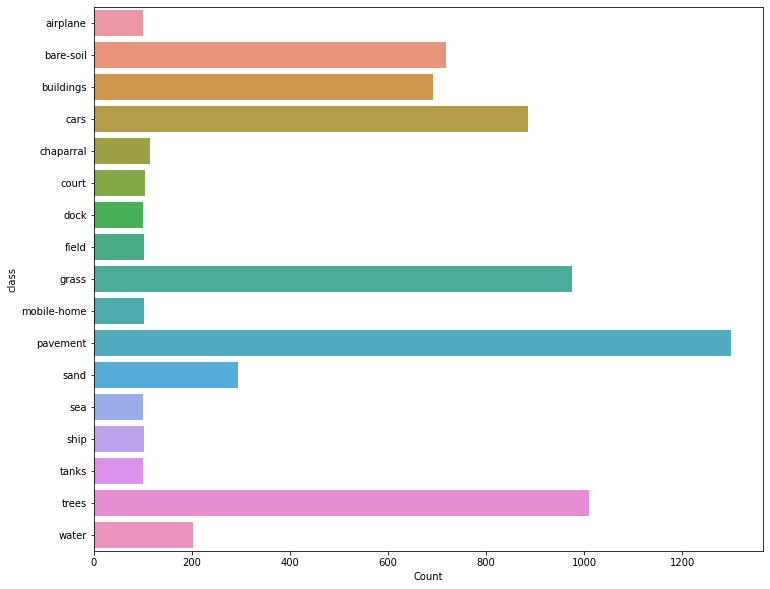

In [7]:
fig, ax= plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count, ax=ax);

In [8]:
list(class_count['class'])

['airplane',
 'bare-soil',
 'buildings',
 'cars',
 'chaparral',
 'court',
 'dock',
 'field',
 'grass',
 'mobile-home',
 'pavement',
 'sand',
 'sea',
 'ship',
 'tanks',
 'trees',
 'water']

In [9]:
path =  Path("UCMerced")
data_src = (ImageList.from_df(df=df, path=path, folder='images', suffix=".tif")
            .split_by_rand_pct(0.2)
            
            .label_from_df(cols=list(class_count['class']), label_cls=MultiCategoryList, one_hot=True))

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
data = (data_src.transform(tfms, size=256).databunch().normalize(imagenet_stats))

In [12]:
data.c

17

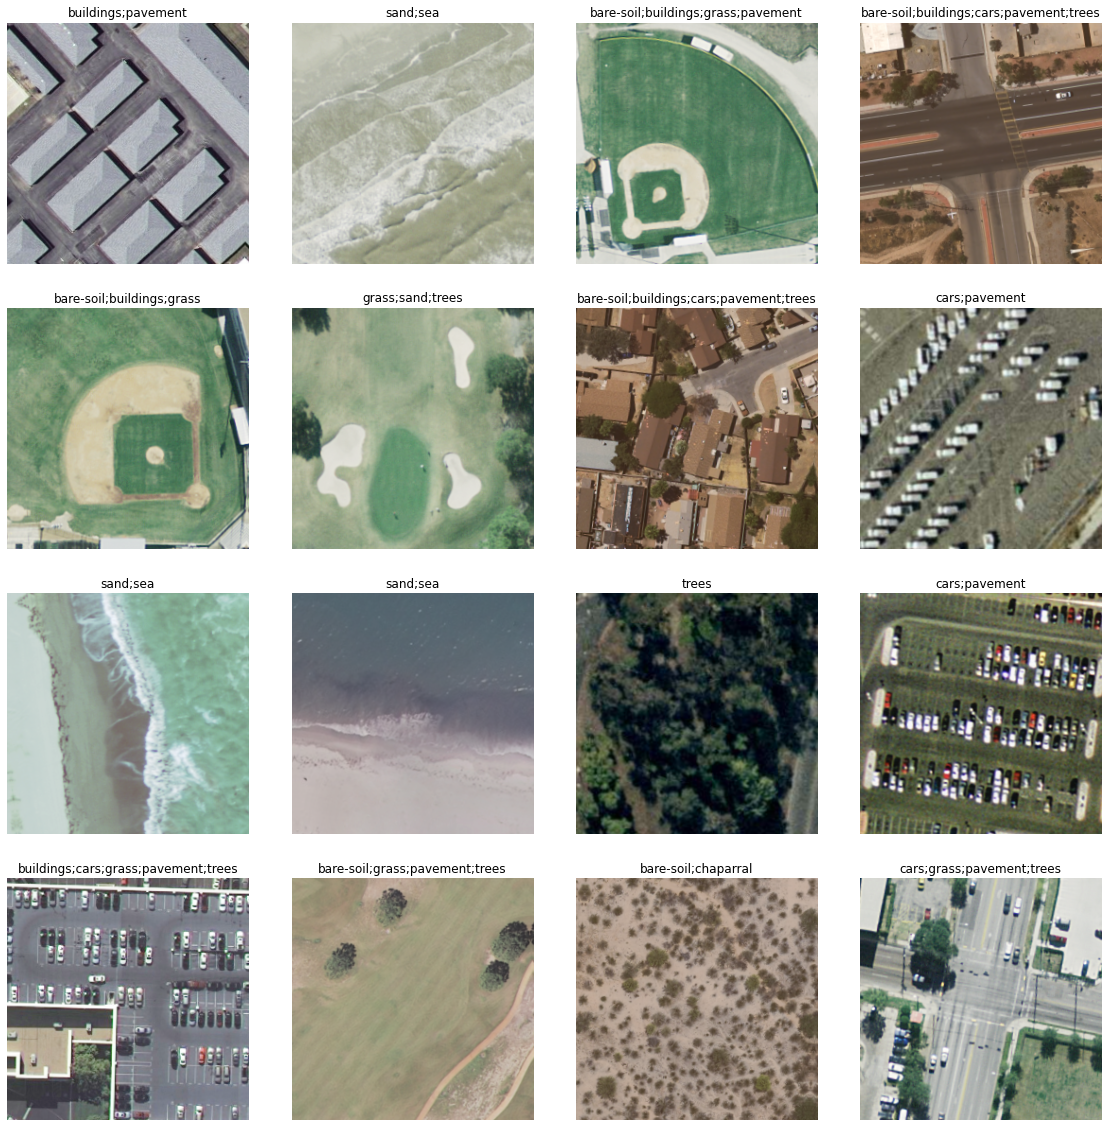

In [13]:
data.show_batch(4)

In [14]:
f_score = partial(fbeta, thresh=0.45)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy_thresh, f_score],
                    callback_fns=[ShowGraph, SaveModelCallback])
# on fait un cree un modele en utilisant le transfert learning
# ici on telecharge le modele restnet34 qui est un modele pre-entraine( transfer-learning)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


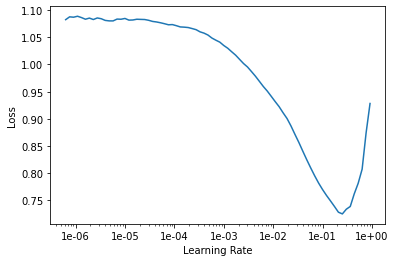

In [16]:
learn.recorder.plot()

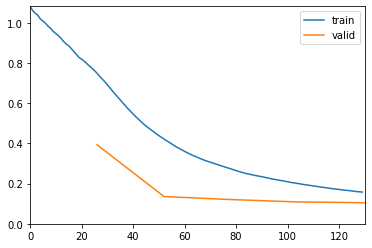

Better model found at epoch 0 with valid_loss value: 0.39375126361846924.
Better model found at epoch 1 with valid_loss value: 0.1358051896095276.
Better model found at epoch 2 with valid_loss value: 0.12073913216590881.
Better model found at epoch 3 with valid_loss value: 0.10890450328588486.
Better model found at epoch 4 with valid_loss value: 0.10502301156520844.


In [17]:
learn.fit_one_cycle(5, 1e-2)

In [18]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


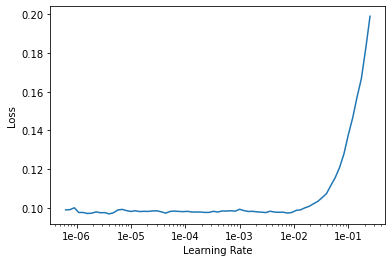

In [19]:
learn.lr_find()
learn.recorder.plot()

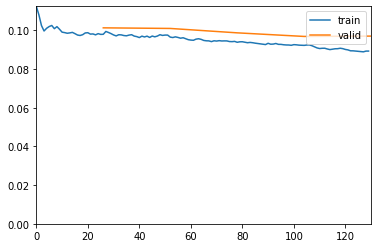

Better model found at epoch 0 with valid_loss value: 0.10125002264976501.
Better model found at epoch 1 with valid_loss value: 0.10093756765127182.
Better model found at epoch 2 with valid_loss value: 0.09866505861282349.
Better model found at epoch 3 with valid_loss value: 0.09680628776550293.


In [20]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr))

In [21]:
!wget https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
!unzip test.zip

--2020-10-08 01:52:57--  https://www.dropbox.com/s/6tt0t61uq2w1n3s/test.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6tt0t61uq2w1n3s/test.zip [following]
--2020-10-08 01:52:57--  https://www.dropbox.com/s/raw/6tt0t61uq2w1n3s/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc288b0c5bed8758fd056766ed27.dl.dropboxusercontent.com/cd/0/inline/BA371PY8Sj53GTctPcEonm-quEa_lGpMg1f4HUEqo4tzdy70z2EX6NfcVMRuEpo5fqnEBxny7hTX-oZVVtFxqBIWn4AEc_0JQcLmz-5zOZ013aeJHPWMxkiBIsNlUA-CaF8/file# [following]
--2020-10-08 01:52:57--  https://uc288b0c5bed8758fd056766ed27.dl.dropboxusercontent.com/cd/0/inline/BA371PY8Sj53GTctPcEonm-quEa_lGpMg1f4HUEqo4tzdy70z2EX6NfcVMRuEpo5fqnEBxny7hTX-oZVVtFxqBIWn4AEc_0JQcLmz-5zOZ013aeJHPWMxkiBIsNlUA

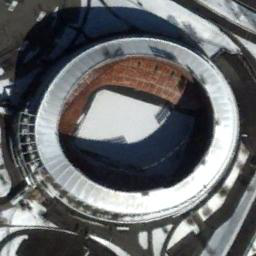

In [22]:
img = open_image("/content/test/stadium_040.jpg")
img

In [23]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [24]:
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

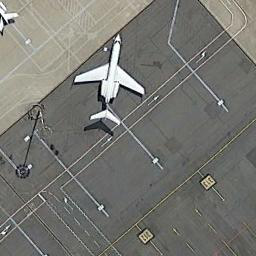

In [24]:
img = open_image("/content/test/airplane_439.jpg")
img

In [25]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [26]:
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

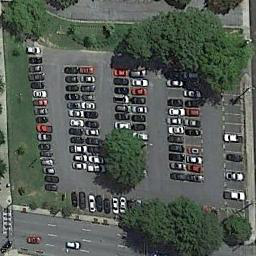

In [27]:
img = open_image("/content/test/parking_lot_032.jpg")
img

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

In [30]:
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

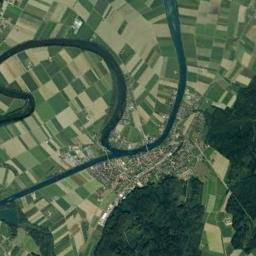

In [29]:
img = open_image("/content/test/river_209.jpg")
img


In [30]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

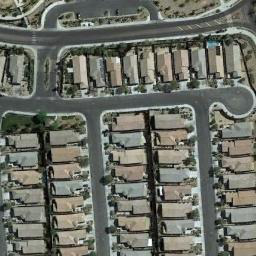

In [31]:
img = open_image("/content/test/dense_residential_025.jpg")
img

In [32]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


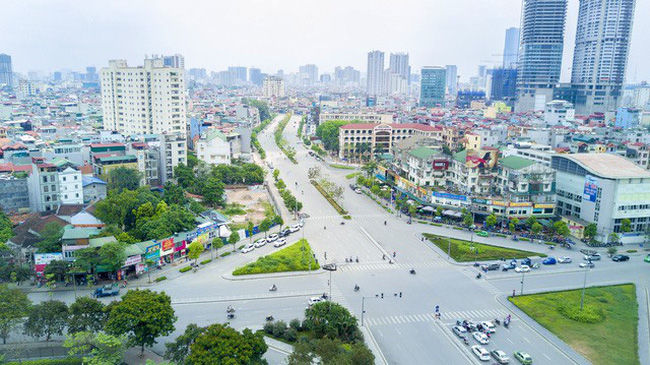

In [34]:
img = open_image("/content/drive/My Drive/Dataset/Image Classification/Classification Image Satellite/small dataset/cau-giay.jpg")
img

In [35]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

In [36]:
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

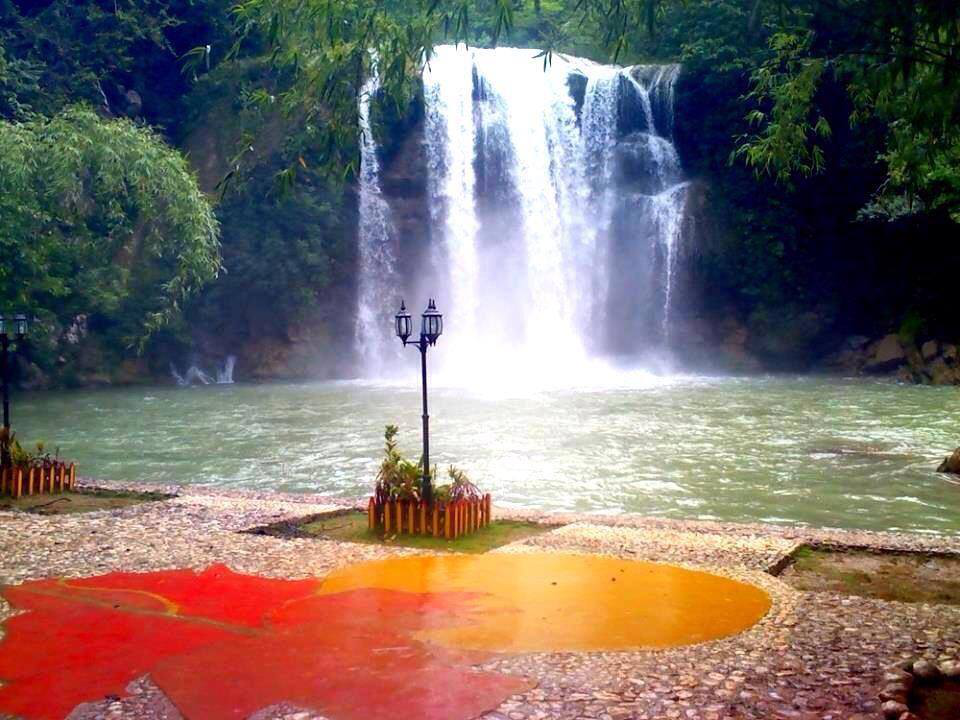

In [37]:
img = open_image("/content/drive/My Drive/Dataset/Image Classification/Classification Image Satellite/small dataset/camp-perrin-haiti.jpg")
img

In [38]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


MultiCategory tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

In [39]:
df.head()

IMAGE\LABEL  airplane  bare-soil  buildings  ...  ship  tanks  trees  water
0  agricultural00         0          0          0  ...     0      0      1      0
1  agricultural01         0          0          0  ...     0      0      0      0
2  agricultural02         0          0          0  ...     0      0      0      0
3  agricultural03         0          0          0  ...     0      0      0      0
4  agricultural04         0          0          0  ...     0      0      1      0

[5 rows x 18 columns]

In [41]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

MultiCategory tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])